# Soil Organic Carbon Data Exploration and DPPD

[Factors that effects SOC](doi.org/10.3390/ijerph17165697) are soil bulk density, elevation, vegetation, clay content, land cover type etc. 
To do data exploration for SOC, following libraries has been imported.

In [1]:
import geopandas as gpd
import pandas as pd
import rasterio
from rasterstats import zonal_stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from osgeo import gdal
import warnings
warnings.filterwarnings('ignore')

/home/luckyw0w/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


To do mandal wise analysis, a funtion has been created to get mean values of within the mandal boundary

In [2]:
def meanvalues(tif):
    
    data = gpd.read_file('TSDM/Mandal_Boundary.shp')  #Mandal (an administrative boundary) Shapefile
    data['index'] = data.index
    
    mean_list = []
    for j in range(len(data)):                #iterating all rows of dataframe to get point info

        stats = zonal_stats(data.iloc[j].geometry, tif, stats="*", categorical=True)         #getting statistics from the raster point 
        i = stats[0]                                                                          #storing statsistical dictionary in a value
        mean = i['mean']
        mean_list.append(mean)
        
    return mean_list

DEM file has been created using SRTM DEM and reprojected to 250m<br>
NDVI created using annual composite of MODIS 16 Days data<br>
Soil Organic Carbon has been created using [SoilGrids](soilgrids.org)<br>
Soil Bulk density has ben created using [SoilGrids](soilgrids.org)<br>
Soil clay content has ben created using [SoilGrids](soilgrids.org)<br>
Telangana state boundary is available on both Telangana Govt. Website and DiCRA github repo<br>
<br>
All datasets has been read and taken mandal wise mean value of those

In [3]:
data = gpd.read_file('TSDM/Mandal_Boundary.shp')  #Mandal (an administrative boundary) Shapefile
data = data.sort_values(by=['Mandal_Nam'])
data['index'] = data.index

soc_mandal = gpd.GeoDataFrame()
soc_mandal['index'] = data.index
soc_mandal['Dist_Name'] = data.Dist_Name

mean_list = meanvalues('SOC_2020_000-005.tif')
soc_mandal['soc'] = mean_list
mean_list = meanvalues('NDVI.tif')
soc_mandal['ndvi'] = mean_list
mean_list = meanvalues('SoilBD_000-005cm.tif')
soc_mandal['bulkdensity'] = mean_list
mean_list = meanvalues('ClayContent_000-005cm.tif')
soc_mandal['clay'] = mean_list
mean_list = meanvalues('DEM.tif')
soc_mandal['dem'] = mean_list

soc_mandal['geometry'] = data.geometry

Soil Organic Carbon and Soil Bulk Density relation

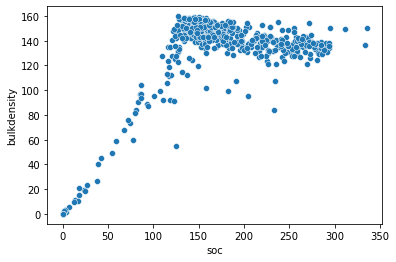

In [4]:
sns.scatterplot(x="soc", y="bulkdensity", data=soc_mandal)

Soil Organic Carbon and NDVI relation

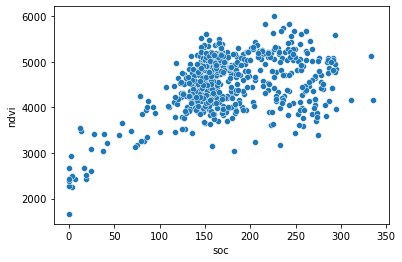

In [5]:
sns.scatterplot(x="soc", y="ndvi", data=soc_mandal)

Soil Organic Carbon and Clay Content relation

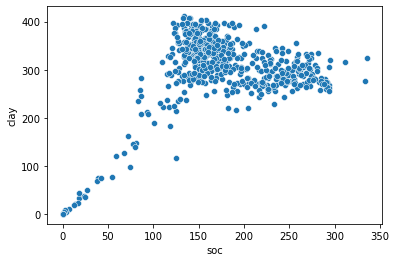

In [6]:
sns.scatterplot(x="soc", y="clay", data=soc_mandal)

Soil Organic Carbon and Elevation relation

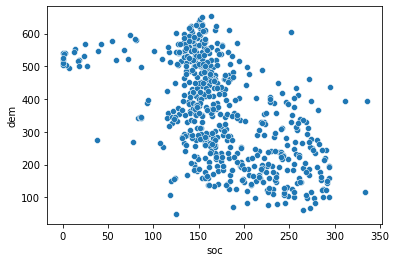

In [7]:
sns.scatterplot(x="soc", y="dem", data=soc_mandal)  

mandal wise averaged maps fr different dataset

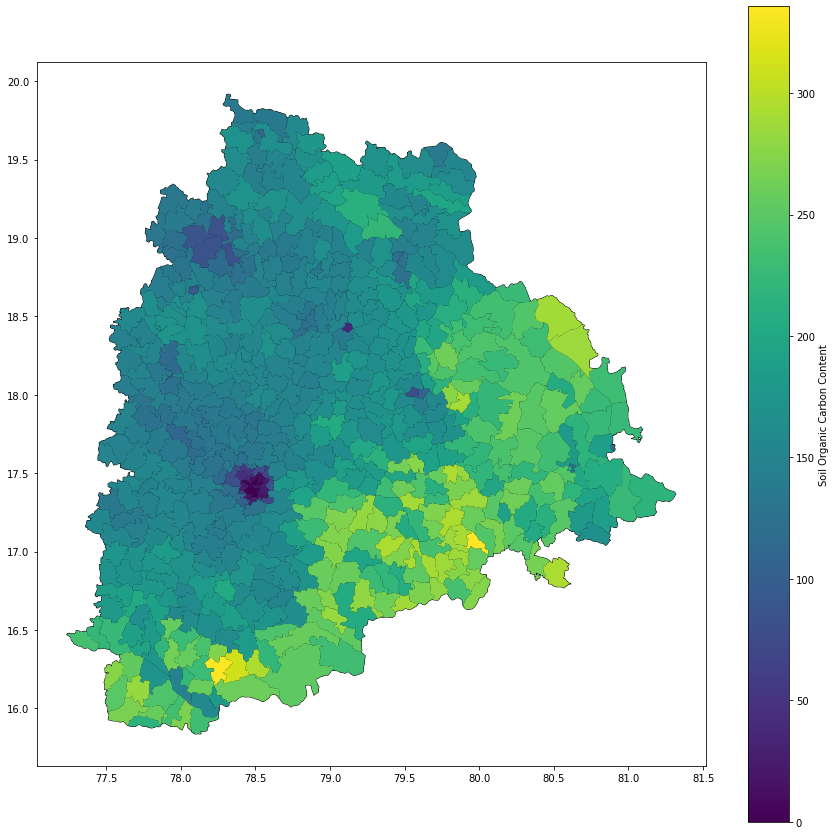

In [8]:
base = soc_mandal.plot(color='white', edgecolor='black', figsize=(15,15))
soc_mandal.plot(column='soc', ax=base, legend=True, legend_kwds={'label': "Soil Organic Carbon Content"}, figsize=(8,8))

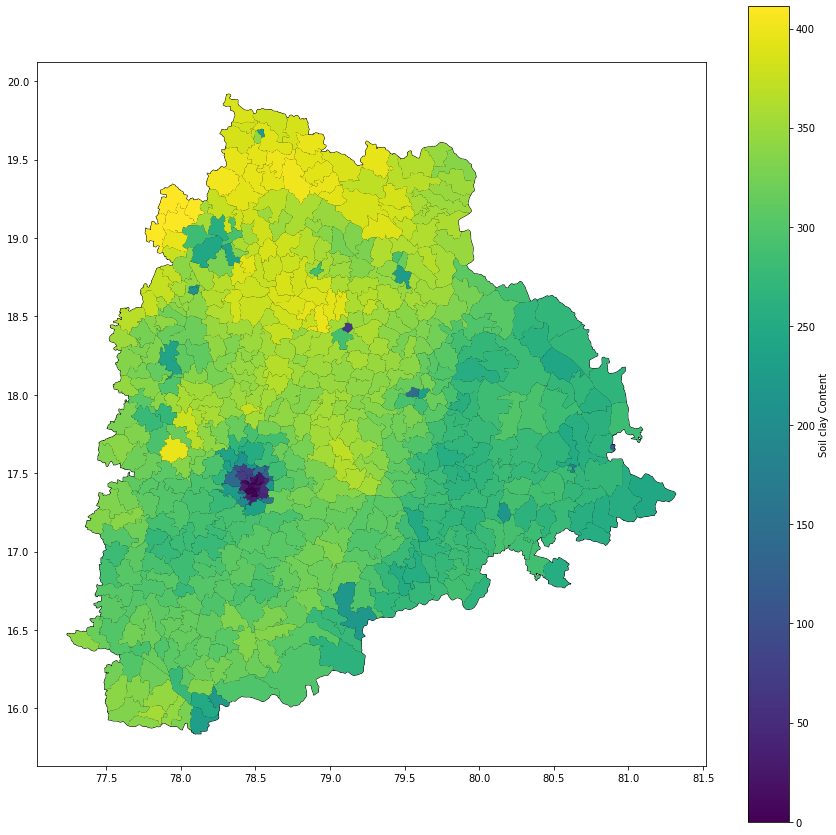

In [9]:
base = soc_mandal.plot(color='white', edgecolor='black', figsize=(15,15))
soc_mandal.plot(column='clay', ax=base, legend=True, legend_kwds={'label': "Soil clay Content"}, figsize=(8,8))

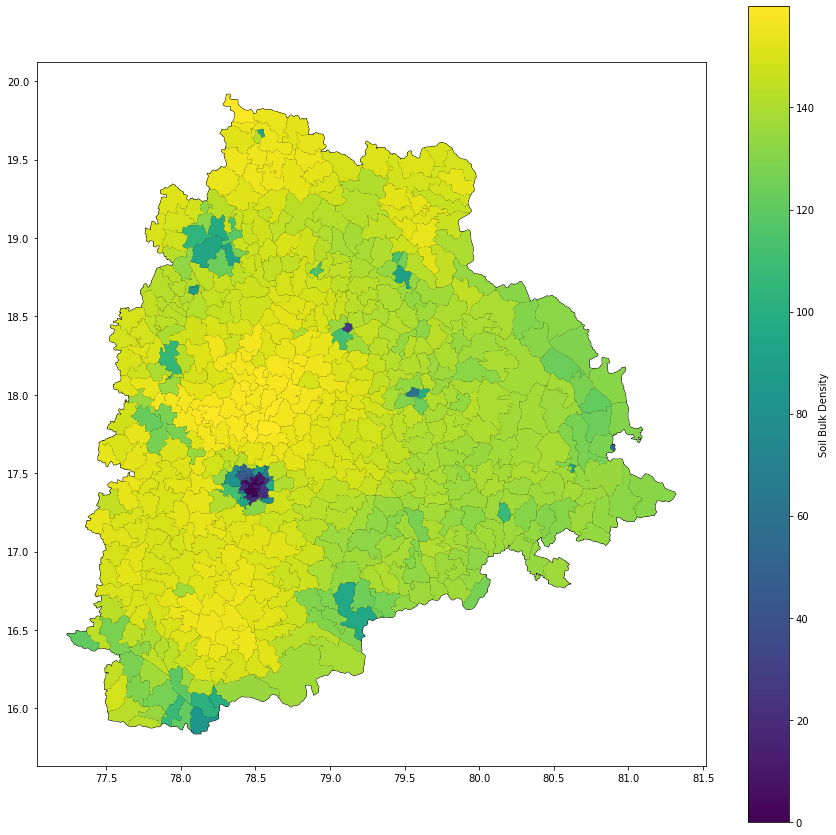

In [10]:
base = soc_mandal.plot(color='white', edgecolor='black', figsize=(15,15))
soc_mandal.plot(column='bulkdensity', ax=base, legend=True, legend_kwds={'label': "Soil Bulk Density"}, figsize=(8,8))

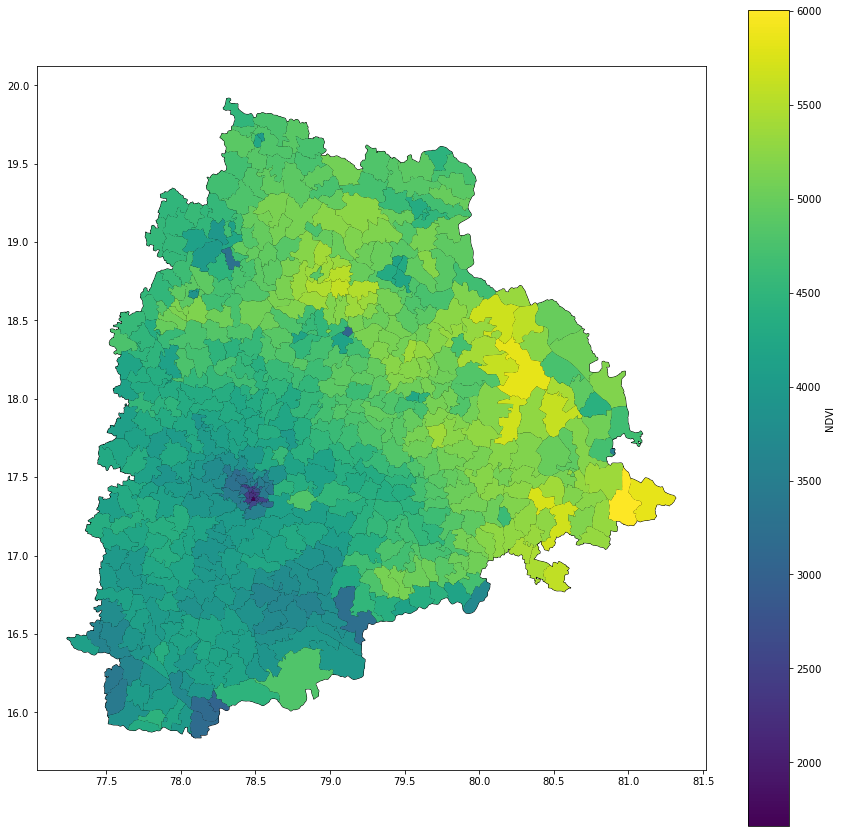

In [11]:
base = soc_mandal.plot(color='white', edgecolor='black', figsize=(15,15))
soc_mandal.plot(column='ndvi', ax=base, legend=True, legend_kwds={'label': "NDVI"}, figsize=(8,8))

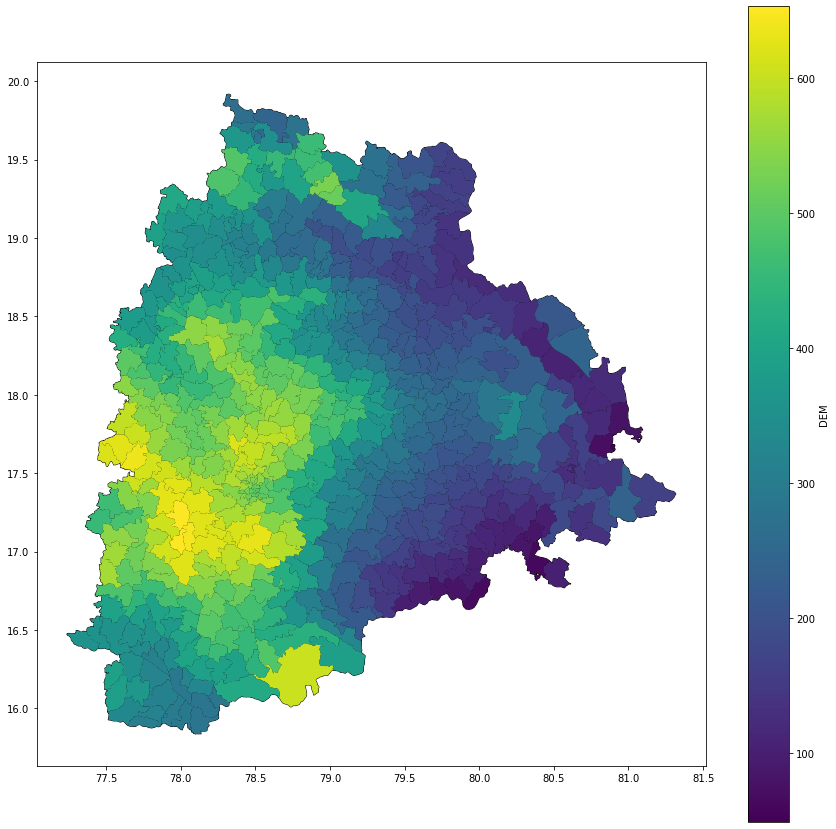

In [12]:
base = soc_mandal.plot(color='white', edgecolor='black', figsize=(15,15))
soc_mandal.plot(column='dem', ax=base, legend=True, legend_kwds={'label': "DEM"}, figsize=(8,8))

From the dataframe which contains all averaged values of the different datasets, the input dataset has been taken as X and SOC took as y. A linear regression model has been built for a relationship between input and output values.<br>
<br>
Predicted values have been matched with true values and normalized to get values between a range of -1 and 1. So -1 shows the maximum SOC negative difference and 1 shows the maximum SOC negative difference. Which can be stated as deviances in SOC in similar conditions of input variables

In [14]:
import numpy as np

X = soc_mandal.values[:,3:7]
y =soc_mandal.soc

reg = LinearRegression().fit(X, y)
y_pred_trend = reg.predict(X)

res = np.subtract(y,y_pred_trend)
norm = (res - res.min())/ (res.max() - res.min())
data_norm = (norm - 0.5)/ 0.5
soc_mandal['y_pred'] = list(y_pred_trend)
soc_mandal['deviance'] = list(data_norm)

In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print('Regression Score: ',reg.score(X, y))
print('Mean Absolute Error: ',mean_absolute_error(y, y_pred_trend))
print('Root Mean Squared Error: ',mean_squared_error(y, y_pred_trend, squared=False))

Regression Score:  0.5923257440014469
Mean Absolute Error:  27.896362630496377
Root Mean Squared Error:  37.10665189313329


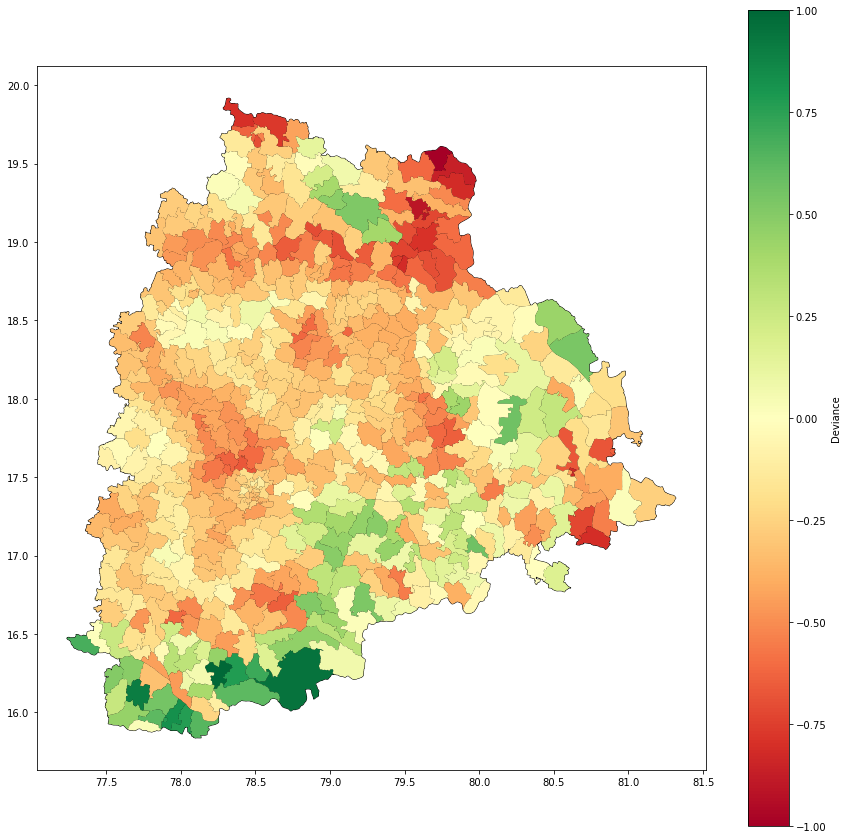

In [16]:
base = soc_mandal.plot(color='white', edgecolor='black', figsize=(15,15))
soc_mandal.plot(column='deviance', ax=base, cmap='RdYlGn', legend=True, legend_kwds={'label': "Deviance"}, figsize=(8,8))